In [1]:
#Importar librerias
import numpy as npf
import pandas as pd
import re
% matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Leemos el archivo y creamos el dataframe "data" (tiene que ser el archivo ya "limpio")
data = pd.read_csv("./DATA/properattilimpio.csv")

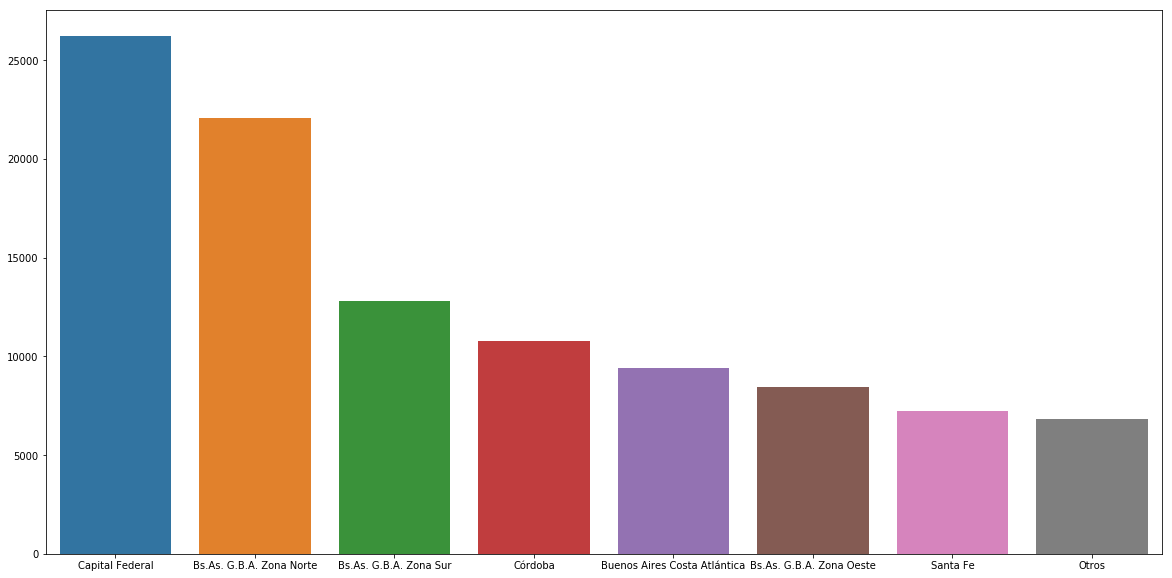

In [3]:
# Cantidad de datos por provincia(barras) - Juan

# Creo dummies para cada provincia en una serie y las ordeno 
dummy = pd.get_dummies(data.PROVINCIA)
propiedades_por_provincia = dummy.sum().sort_values(ascending = False)

# Para acortar el gráfico saco las provincias con menos de 2500 registros y las agrupo en "otros"
o = 0
for p in propiedades_por_provincia:
    if p < 2500:
        o += p
otros = pd.Series([o], index=['Otros'])  
propiedades_por_provincia = propiedades_por_provincia.append(otros)
propiedades_por_provincia = propiedades_por_provincia[propiedades_por_provincia > 2500]

# Gráfico
plt.figure(figsize = (20,10))
graph = sns.barplot(propiedades_por_provincia.index, propiedades_por_provincia.values)

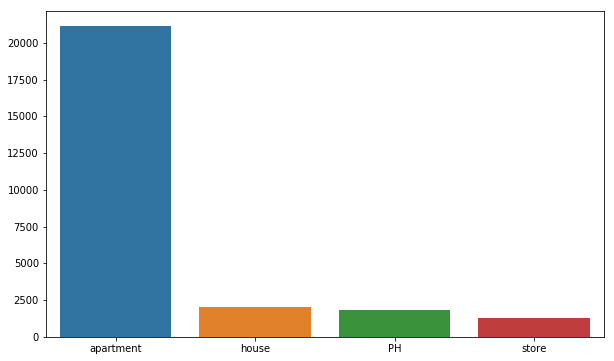

In [4]:
# Cantidad de datos por tipo de propiedad (barras) - Juan

# Creo dummies para cada provincia en una serie y las ordeno 
dummy = pd.get_dummies(data.TIPO_PROPIEDAD[data['PROVINCIA'] == 'Capital Federal'])
tipo_propiedad = dummy.sum().sort_values(ascending = False)
tipo_propiedad

# Gráfico
plt.figure(figsize = (10,6))
graph = sns.barplot(tipo_propiedad.index, tipo_propiedad.values)

In [ ]:
# m2 vs U$S (dispersión)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


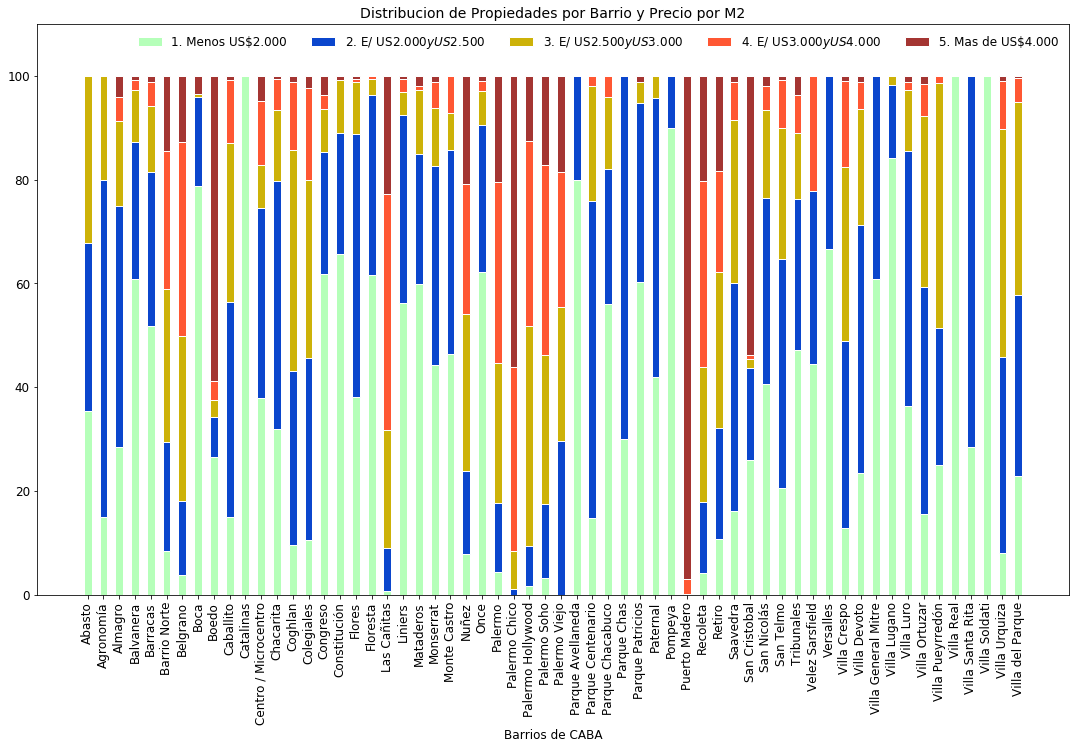

In [6]:
# rangos de U$S/m2 vs Barrio (barras) - Gabi

#Filtro datos solo de capital federal DEPARTAMENTO
df_grafico = data[(data['TIPO_PROPIEDAD'] == 'apartment') & (data['PROVINCIA'] == 'Capital Federal') & (data['BARRIO'] != 'SIN DATO')]

#CALCULO PRECIO POR METRO CUADRADO. Deberia cambiarlo por la columna que corresponda cuando este
df_grafico['US$_por_M2'] = df_grafico['price_aprox_usd']/df_grafico['surface_total_in_m2']

#Solo me quedo con las columnas que necesito
df_grafico = df_grafico[['BARRIO', 'US$_por_M2']]

#Funcion para calcular Rangos
def rangos(row):
    if row['US$_por_M2'] <= 2000:
        return '1. Menos US$2.000'
    elif row['US$_por_M2'] <= 2500:
        return '2. E/ US$2.000 y  US$2.500'
    elif row['US$_por_M2'] <= 3000:
        return '3. E/ US$2.500 y  US$3.000'
    elif row['US$_por_M2'] <= 4000:
        return '4. E/ US$3.000 y  US$4.000'
    elif row['US$_por_M2'] > 4000:
        return '5. Mas de US$4.000'
    else:
        return 'ver'

#Aplico funcion a cada registro
df_grafico['Rangos_US$_por_M2'] =  df_grafico.apply(rangos, axis=1)
#SACAMOS LOS VER QUE SON NAN
df_grafico = df_grafico[df_grafico['Rangos_US$_por_M2'] != 'ver']

#Creo un dataframe con BARRIO - RANGOS - CANTIDAD
df_grafico = pd.DataFrame({'count' : df_grafico.groupby( ['BARRIO','Rangos_US$_por_M2'] ).size()}).reset_index()

#Crear dataframe con todas las combinaciones de BARRIO Y RANGOS. Luego left join y a los que queden vacios completarlos con 0.
#Esto se hace para tener para cada barrio todos los rangos

barrio_df = pd.DataFrame({'BARRIO': npf.unique(df_grafico[['BARRIO']])})
rangos_df = pd.DataFrame({'Rangos_US$_por_M2': npf.unique(df_grafico[['Rangos_US$_por_M2']])})
barrio_df['key'] = 0
rangos_df['key'] = 0
df_barrio_rangos = pd.merge(barrio_df,rangos_df,on = 'key' ,how = 'outer')

aux = pd.merge(df_barrio_rangos,df_grafico, on = ['BARRIO','Rangos_US$_por_M2'],how='left')
df_grafico = aux.fillna(0)

###############################G   R   A   F   I   C   O##################################################
# df_grafico
r = list(npf.unique(df_grafico['BARRIO']))
raw_data = {'greenBars': list(df_grafico[df_grafico['Rangos_US$_por_M2'] == '1. Menos US$2.000']['count']),
            'blueBars': list(df_grafico[df_grafico['Rangos_US$_por_M2'] == '2. E/ US$2.000 y  US$2.500']['count']),
            'yellowBars': list(df_grafico[df_grafico['Rangos_US$_por_M2'] == '3. E/ US$2.500 y  US$3.000']['count']),
            'orangeBars': list(df_grafico[df_grafico['Rangos_US$_por_M2'] == '4. E/ US$3.000 y  US$4.000']['count']),
            'redBars': list(df_grafico[df_grafico['Rangos_US$_por_M2'] == '5. Mas de US$4.000']['count'])
           }

df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k+l+m for i,j,k,l,m in zip(df['greenBars'], df['orangeBars'], df['blueBars'], df['yellowBars'], df['redBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
yellowBars = [i / j * 100 for i,j in zip(df['yellowBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
redBars = [i / j * 100 for i,j in zip(df['redBars'], totals)]
 
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)    
    
# plot
barWidth = 0.5
names = list(npf.unique(df_grafico['Rangos_US$_por_M2']))
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label= '1. Menos US$2.000')
# Create blue Bars
plt.bar(r, blueBars, bottom=greenBars, color='#0B46CD', edgecolor='white', width=barWidth, label =  '2. E/ US$2.000 y  US$2.500')
# Create Yellow Bars
plt.bar(r, yellowBars, bottom=[i+j for i,j in zip(greenBars, blueBars)], color='#CDB208', edgecolor='white', width=barWidth, label='3. E/ US$2.500 y  US$3.000')
# Create Organge Bars
plt.bar(r, orangeBars, bottom=[i+j+k for i,j,k in zip(greenBars, blueBars, yellowBars)], color='#FF5733', edgecolor='white', width=barWidth, label = '4. E/ US$3.000 y  US$4.000')
# Create Red Bars
plt.bar(r, redBars, bottom=[i+j+k+l for i,j,k,l in zip(greenBars, blueBars, yellowBars,orangeBars)], color='#A43532', edgecolor='white', width=barWidth, label ='5. Mas de US$4.000')
 
    
#
plt.title('Distribucion de Propiedades por Barrio y Precio por M2', fontsize = 14)
# y axis
plt.ylim([0,110])
plt.yticks(fontsize= 12)
#plt.ylabel(output, fontsize=8)

# Custom x axis
plt.xticks(r, fontsize = 12 , rotation = 90)
plt.xlabel("Barrios de CABA",fontsize=12)
 
    
# Add a legend
plt.legend(loc='upper right', ncol = 5, fontsize=12, framealpha=0, fancybox=True)
 
# Show graphic
plt.show()


#En el grafioc se ve que los que tienen mas rojo o naranja son barrios caros,
#mientras que los que tienen mas verde o azul son mas economicos

In [ ]:
# U$S/m2 vs dummies(boxplot)

In [ ]:
# U$S/m2 vs ambientes (boxplot)

In [ ]:
# U$S x ubicación (mapa de calor) - Santi